### Project: Training and Classifying of Electrical Parts Images into Catgeories

Steps:

- Data Collection & Arranging them into Categorized Folders
- Train-Val-Test Split
- Loading Train & Val Through Image Data Generator
    - Pre-Processing Steps
        - Data Augmentation (if required)
        - Resize
        - Normalization of Images  
- Model Building (CNN+ANN)
- Model Training on Train and Val Generators
- Evaluations
- Predictions on Test
- Real Time Prediction

**0. Images Data**

- Data Taken from Kaggle
- Contains train, val, test folder with each folder categorized folders and color images
    - Each Image having default size of 224*224
    

In [1]:
import shutil
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import os # folders & files operations
import matplotlib.image as mpimg # image read
import matplotlib.pyplot as plt # image display
import os # folders & files operations
import matplotlib.image as mpimg # image read
import matplotlib.pyplot as plt # image display

In [2]:
# Selecting Kaggle Input Folder for Images

os.chdir('/kaggle/input/images/image classification')

In [3]:
os.listdir()

['crank shaft',
 'beval gear',
 'DC Motors',
 'pistons',
 'motor winding',
 'Ac Motors',
 'spur gear']

## Train,Test,Validation Data

In [4]:
def train_val_test_split(root_dir=r'/kaggle/input/images/image classification' ,
                         processed_dir='Tribe_split',    # source: one subfolder per classprocessed_dir='Tribes.split',   # destination root
                         test_ratio=0.20,           # fraction of total
                         val_ratio=0.10,            # fraction of total
                         seed=42,                   # for reproducibility
                         overwrite=False            # if True, remove existing processed_dir first
                        ):
    print("########### Train / Val / Test Split started ###########")
    assert 0 < test_ratio < 1 and 0 < val_ratio < 1, "ratios must be in (0,1)"
    assert (test_ratio + val_ratio) < 1, "test_ratio + val_ratio must be < 1"

    # Prepare destination
    if overwrite and os.path.exists(processed_dir):
        shutil.rmtree(processed_dir)

    splits = ['train', 'val', 'test']

    # List class folders only
    classes_dir = [d for d in os.listdir(root_dir)
                   if os.path.isdir(os.path.join(root_dir, d))]

    for cls in classes_dir:
        print(f"$$$ Class Name: {cls} $$$")

        src = os.path.join(root_dir, cls)

        # All files in class folder (skip hidden)
        allFileNames = [f for f in os.listdir(src)
                        if not f.startswith('.')
                        and os.path.isfile(os.path.join(src, f))]

        if len(allFileNames) == 0:
            print(f"⚠️  No files found in {src}, skipping.")
            continue

        # Reproducible shuffle
        rng = np.random.RandomState(seed)
        allFileNames = rng.permutation(np.array(allFileNames))

        n_total = len(allFileNames)
        n_test = int(n_total * test_ratio)
        n_val  = int(n_total * val_ratio)
        n_train = n_total - n_test - n_val

        # Split indices
        test_files  = allFileNames[:n_test]
        val_files   = allFileNames[n_test:n_test + n_val]
        train_files = allFileNames[n_test + n_val:]

        # Report
        print(f"Total images: {n_total}")
        print(f"Training:    {len(train_files)}")
        print(f"Validation:  {len(val_files)}")
        print(f"Testing:     {len(test_files)}\n")

        # Make destination class dirs
        for sp in splits:
            os.makedirs(os.path.join(processed_dir, sp, cls), exist_ok=True)

        # Helper to copy a list of filenames to a split dir
        def _copy_many(file_list, split_name):
            dst_dir = os.path.join(processed_dir, split_name, cls)
            for name in file_list:
                shutil.copy2(os.path.join(src, name), dst_dir)

        _copy_many(train_files, 'train')
        _copy_many(val_files, 'val')
        _copy_many(test_files, 'test')

In [5]:
train_val_test_split(root_dir=r'/kaggle/input/images/image classification', processed_dir='/kaggle/working/CNNData',overwrite=True)

########### Train / Val / Test Split started ###########
$$$ Class Name: crank shaft $$$
Total images: 358
Training:    252
Validation:  35
Testing:     71

$$$ Class Name: beval gear $$$
Total images: 323
Training:    227
Validation:  32
Testing:     64

$$$ Class Name: DC Motors $$$
Total images: 371
Training:    260
Validation:  37
Testing:     74

$$$ Class Name: pistons $$$
Total images: 324
Training:    228
Validation:  32
Testing:     64

$$$ Class Name: motor winding $$$
Total images: 325
Training:    228
Validation:  32
Testing:     65

$$$ Class Name: Ac Motors $$$
Total images: 299
Training:    211
Validation:  29
Testing:     59

$$$ Class Name: spur gear $$$
Total images: 335
Training:    235
Validation:  33
Testing:     67



In [6]:
# Checking number of images in folders

for folder in ['/kaggle/working/CNNData/train', '/kaggle/working/CNNData/val', '/kaggle/working/CNNData/test']:
    print("Folder:", folder.title())
    classes = os.listdir("/kaggle/working/CNNData/train")
    for cls in classes:
        print(f"{cls}:", len(os.listdir(folder+"/"+cls)))
    print()

Folder: /Kaggle/Working/Cnndata/Train
Ac Motors: 211
DC Motors: 260
pistons: 228
crank shaft: 252
motor winding: 228
spur gear: 235
beval gear: 227

Folder: /Kaggle/Working/Cnndata/Val
Ac Motors: 29
DC Motors: 37
pistons: 32
crank shaft: 35
motor winding: 32
spur gear: 33
beval gear: 32

Folder: /Kaggle/Working/Cnndata/Test
Ac Motors: 59
DC Motors: 74
pistons: 64
crank shaft: 71
motor winding: 65
spur gear: 67
beval gear: 64



**Loading Train Data & Displaying Sample**

**1. Data Loading - Image Data Generator**

In [7]:
# Module
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-10-06 11:21:27.118086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759749687.349012      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759749687.417765      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Taking Train & Validation Images**

In [10]:
# Defining generators with Data Augmentation : Because We have Small Size Data

train_datagen = ImageDataGenerator(
    rescale=1./255,        # normalize pixels to [0,1]
    # Image Data Augmentation Params
    rotation_range=15,     # random rotations
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,  # mirror images
    fill_mode='nearest',   # fill empty pixels after transforms
)

val_datagen = ImageDataGenerator(rescale=1./255)  # no augmentation for val/test

In [11]:
# Create iterators from directory
train = train_datagen.flow_from_directory(
    '/kaggle/working/CNNData/train',
    target_size=(224, 224),   # resize all images
    batch_size=32,            # Number of Images for Batch to Train
    class_mode='categorical', # or 'binary' for 7 classes
    shuffle=True,
    seed=42
)

val = val_datagen.flow_from_directory(
    '/kaggle/working/CNNData/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1606 images belonging to 7 classes.
Found 224 images belonging to 7 classes.


Images as X & Folder/Class Names as y

**Sample X & y View from Train Gen**

In [12]:
X_batch, y_batch = next(train)   # or: X_batch, y_batch = train_gen.next()
print(X_batch.shape, y_batch.shape)  # (batch_size, H, W, C), (batch_size, num_classes or 1)

(32, 224, 224, 3) (32, 7)


In [13]:
X_batch[0]

array([[[0.23827717, 0.13216764, 0.0572035 ],
        [0.23385254, 0.13799661, 0.07336489],
        [0.21594094, 0.13463567, 0.07411329],
        ...,
        [0.16470589, 0.12156864, 0.01176471],
        [0.16470589, 0.12156864, 0.01176471],
        [0.22146404, 0.17677176, 0.06152528]],

       [[0.24496104, 0.1373662 , 0.05943145],
        [0.22865397, 0.1305701 , 0.06519572],
        [0.22633806, 0.14206219, 0.08079716],
        ...,
        [0.37805325, 0.32907087, 0.19880895],
        [0.43716016, 0.3865584 , 0.2506287 ],
        [0.4726932 , 0.4204721 , 0.279495  ]],

       [[0.2516449 , 0.14256476, 0.06165941],
        [0.2234554 , 0.12314358, 0.05702655],
        [0.2367352 , 0.14948872, 0.08748102],
        ...,
        [0.5477702 , 0.49125898, 0.33741152],
        [0.5761091 , 0.51797855, 0.359273  ],
        [0.5873089 , 0.5270957 , 0.36770102]],

       ...,

       [[0.0619645 , 0.06314005, 0.01373014],
        [0.05872577, 0.060711  , 0.00968172],
        [0.05548704, 0

In [14]:
y_batch[0]

array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

* Above array represents one hot encoding of output column as we have multi class

In [15]:
train.class_indices

{'Ac Motors': 0,
 'DC Motors': 1,
 'beval gear': 2,
 'crank shaft': 3,
 'motor winding': 4,
 'pistons': 5,
 'spur gear': 6}

**2. Model Building**

* Building CNN (to Extract Image Features) +ANN (Classification) Architecture
    * Below are the layers for each Network
    * CNN
        * Convolution Layer
        * Pooling Layer
        * Flatten Layer
    * ANN @ Fully Connected Layer
        * Hidden Layers
        * Output Layer

* **Model Architecture Flow:**
    - Convolutional Layers followed by MaxPooling Layers.
    - The Flatten layer to flatten the output of the convolutional layer.
    - Then we will have fully connected layers followed by the output of the flattened layer.
    - The final layer is the output layer which has the activation function softmax, gives each class prob.
        
    Note: To handle Overfitting , we can given kernel regularizer parameter (l1 or l2) or dropout layers

In [16]:
from keras import Sequential
from keras.layers import Conv2D, Activation, MaxPool2D, Dropout, Flatten, Dense

**Model Intialization**

In [17]:
model = Sequential(name="TribeImageClassification")

**2.1 CNN Layers**

**Convolution Layer + Activation**
* Convolution of image with different filters
    params: filters, kernel_size, stride size, input shape

    Note:
    * Padding is another param where we can send the original image size through the entire convolution , it will add an extra pixel to the input image

    * relu is used to deal with non-linearity in the convolution

In [18]:
model.add(Conv2D(32, kernel_size=(3,3), strides=(2,2), input_shape=(224,224,3), name="Conv1"))
model.add(Activation('relu'))
model.summary()

2025-10-06 11:22:17.723640: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

* Output image size = (w-f+2p/s)+1

        here w(width) = 224, f(kernel_size) = 3, p(padding) = 0 (used to balance filter on image), s(stride) = 2

        applying above we will get 111*111*32

* weights/params = ((kernel_size x previous filters) x current filters) + bias (no of current filters)

            kernel_size = (3,3)
            previous filters = 3 (channels)
            current filters = 32
            bias = 32

    total - 896

**Pooling**

* Getting max pixel values from convolution feature maps

    params: pool_size, strides

In [19]:
model.add(MaxPool2D((2,2), strides=(2,2), name="Pool1"))

In [20]:
model.summary()

Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 55, 55, 32)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

* output image size = (w-f/s)+1

      here w(width) = 63, f(kernel_size) = 2, s(stride) = 2

      applying above we will get 31*31*32

* no weights & biases

**Adding Extra Convolution+Pooling Layer (Optional) - To control the Flatten Output**

In [21]:
model.add(Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), name='Conv2'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(1,1), name='Pool2'))

In [22]:
model.add(Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), name='Conv3'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(1,1), name='Pool3'))

In [23]:
model.summary()

Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 27, 27, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 13, 13, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 12, 12, 64)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,600 (100.00 KB)

 Trainable params: 25,600 (100.00 KB)

 Non-trainable params: 0 (0.00 B)

* **Flatten Layer**

In [24]:
model.add(Flatten(name='Flatten'))

In [25]:
model.summary()

Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 27, 27, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 13, 13, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 9216)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,600 (100.00 KB)

 Trainable params: 25,600 (100.00 KB)

 Non-trainable params: 0 (0.00 B)

**2.2 ANN (Fully Connected Layer) with Output**
                                       (Input: Flatten)

In [26]:
# Following Dense Layer Thumb Rule: n/2 -> Flatten/2
model.add(Dense(kernel_initializer='random_uniform', activation='relu', units=4096, name='HiddenLayer1'))
model.add(Dense(kernel_initializer='random_uniform', activation='relu', units=2048, name='HiddenLayer2'))
model.add(Dense(kernel_initializer='random_uniform', activation='relu', units=1024, name='HiddenLayer3'))
model.add(Dense(kernel_initializer='random_uniform', activation='relu', units=512, name='HiddenLayer4'))

In [27]:
model.summary()

Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 27, 27, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 13, 13, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer1 (Dense)            │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer2 (Dense)            │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer3 (Dense)            │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer4 (Dense)            │ (None, 512)            │       524,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,792,064 (186.13 MB)

 Trainable params: 48,792,064 (186.13 MB)

 Non-trainable params: 0 (0.00 B)

**Output Layer**

In [28]:
# we have 7 classes in output , softmax will give each class probability

model.add(Dense(kernel_initializer='random_uniform', activation='softmax', units=7, name='OutputLayer1'))
model.summary()

Model: "TribeImageClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 27, 27, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 13, 13, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer1 (Dense)            │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer2 (Dense)            │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer3 (Dense)            │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer4 (Dense)            │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer1 (Dense)            │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,795,655 (186.14 MB)

 Trainable params: 48,795,655 (186.14 MB)

 Non-trainable params: 0 (0.00 B)

**2.3 Compile Params**

In [29]:
# Compile Params

model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

# We can also Try with different optimizers

**3. Model Training**

* We can use Call Backs [Model CheckPoints, EarlyStopping] if needed

In [30]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

ES = EarlyStopping(
    monitor='val_loss', # Same as the
    patience=5, # Wait for 5 epochs before stopping the training
    verbose=1,
    restore_best_weights='True', # Restore model weights from the epoch with the best value of the monitored quantity.
    min_delta=0.1
)

MC = ModelCheckpoint(
    '/kaggle/working/ImageClassify_Best.h5', # We can also provide full path to the folder to save model
    monitor='val_loss',  # Monitor other things like val_accuracy or accuracy
    save_best_only='True', # Make sure to save only the best model
    verbose=1
)

In [32]:
# Taking fit method
# Takes time to run based on number of parameter training

import warnings
warnings.filterwarnings("ignore")

model.fit(train, validation_data=val, epochs=6, callbacks=[ES,MC])

# No need of ytrain/ytest , because image data generator takes class names from given images folder names
# Workers parameter will uses avaiable cores in cpu: workers=-1 means consider all cores available for faster execution

Epoch 1/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4577 - loss: 1.3564
Epoch 1: val_loss improved from 1.41867 to 1.41379, saving model to /kaggle/working/ImageClassify_Best.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4582 - loss: 1.3556 - val_accuracy: 0.4866 - val_loss: 1.4138
Epoch 2/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5016 - loss: 1.2854
Epoch 2: val_loss improved from 1.41379 to 1.29000, saving model to /kaggle/working/ImageClassify_Best.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5017 - loss: 1.2852 - val_accuracy: 0.5045 - val_loss: 1.2900
Epoch 3/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5338 - loss: 1.2238
Epoch 3: val_loss improved from 1.29000 to 1.24898, saving model to /kaggle/working/ImageClassify_Best.h5
51/51 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5335 - loss: 1.2240 - val_accuracy: 0.5000 - val_loss: 1.2490
Epoch 4/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5546 - loss: 1.1681
Epoch 4: 

**Training Visualization**

In [33]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

title="Training Curves"
smooth=None

# Accept History or plain dict
hist = model.history.history if hasattr(model, "history") else history

# Handle metric key variants
acc_key = "accuracy" if "accuracy" in hist else "acc"
val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"

# Extract series
acc = list(hist.get(acc_key, []))
val_acc = list(hist.get(val_acc_key, []))
loss = list(hist.get("loss", []))
val_loss = list(hist.get("val_loss", []))
epochs = list(range(1, max(map(len, [acc, val_acc, loss, val_loss])) + 1))

# Optional EMA smoothing
def ema(xs, alpha):
    if not xs or smooth is None: return xs
    out = [xs[0]]
    for x in xs[1:]:
        out.append(alpha * x + (1 - alpha) * out[-1])
    return out

if smooth is not None:
    acc = ema(acc, smooth)
    val_acc = ema(val_acc, smooth)
    loss = ema(loss, smooth)
    val_loss = ema(val_loss, smooth)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Accuracy", "Loss"),
    horizontal_spacing=0.12
)

# Accuracy panel
if acc:
    fig.add_trace(go.Scatter(x=epochs[:len(acc)], y=acc, mode="lines+markers",
                             name="Train Acc"), row=1, col=1)
if val_acc:
    fig.add_trace(go.Scatter(x=epochs[:len(val_acc)], y=val_acc, mode="lines+markers",
                             name="Val Acc"), row=1, col=1)

# Loss panel
if loss:
    fig.add_trace(go.Scatter(x=epochs[:len(loss)], y=loss, mode="lines+markers",
                             name="Train Loss"), row=1, col=2)
if val_loss:
    fig.add_trace(go.Scatter(x=epochs[:len(val_loss)], y=val_loss, mode="lines+markers",
                             name="Val Loss"), row=1, col=2)

fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=2)

fig.update_layout(
    title=dict(
        text=title,
        y=0.98,              # keep title near the very top
        x=0.5,               # center align
        xanchor="center",
        yanchor="top"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,              # just below title
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=120, r=20, b=40, l=60),  # give enough space
    height=450
)
fig.show()

**Notes:**
* We can tune model performance by
    - Hyp Param Tuning (conv+pool layers adding, filters, kernel sizes, strides, ANN Hidden Layers, etc..)
    - Dropout layers
    - Regularizations
    - Epochs, Batch Size Tuning

**4. Test Predictions**
- Loading Test Images for Predictions

In [34]:
# Using Validation generator for Images Loading

test =  val_datagen.flow_from_directory(
    '/kaggle/working/CNNData/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predicitons on Loaded Images
predictions = model.predict(test) # Will generate probabilities of 7 classes for each image

Found 454 images belonging to 7 classes.
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step


In [36]:
classes = {v: k for k, v in train.class_indices.items()} # Taking Class Names for Indexes

import numpy as np

output = []
# Going thorugh each images probabilities and identifying max prob class
for prediction in predictions:
    # Mapping high probability class index number with class name
    cls = classes[np.argmax(prediction)]
    output.append(cls)

print(output)

['Ac Motors', 'Ac Motors', 'Ac Motors', 'DC Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'crank shaft', 'Ac Motors', 'spur gear', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'beval gear', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'DC Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'Ac Motors', 'crank shaft', 'beval gear', 'Ac Motors', 'beval gear', 'Ac Motors', 'Ac Motors', 'motor winding', 'DC Motors', 'Ac Motors', 'crank shaft', 'DC Motors', 'DC Motors', 'Ac Motors', 'Ac Motors', 'DC Motors', 'DC Motors', 'DC Motors', 'DC Motors', 'DC Motors', 'Ac Motors', 'DC Motors', 'DC Motors', 'beval gear', 'DC Motors', 'DC Motors

**5. Real time Prediction**
   * **Prediction on given Images**

In [ ]:
# Writing a Function for prediction of given image

# import cv2
# import numpy as np

# def classify(frame):
#     # Converting Image Size to Cnn Input Size
#     img=cv2.resize(frame,(224,224))

#     #scaling to 0 to 1 range
#     if(np.max(img)>1):
#         img = img/255.0

#     img = np.array([img])
#     prediction = model.predict(img)[0] # will predict 12 classes probabilities
#     # Taking Class Names & Numbers for Prediction from train data generator
#     classes = {v: k for k, v in train.class_indices.items()}
#     # mapping high probability class index number with class name
#     cls = classes[np.argmax(prediction)]

#     return cls # output class name

In [37]:
import cv2
import numpy as np
def classify(frame):
    # ensure 3 channels
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    else:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # resize to match model input
    img = cv2.resize(frame, (224, 224))

    # normalize
    img = img / 255.0

    # expand dimensions for batch
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0]
    classes = {v: k for k, v in train.class_indices.items()}
    cls = classes[np.argmax(prediction)]
    return cls

* **Taking Sample Images from Test Images given**

In [41]:
import glob

images = glob.glob("/kaggle/input/images/image classification/pistons/imgi_103_images.jpg")

In [42]:
images

['/kaggle/input/images/image classification/pistons/imgi_103_images.jpg']

* **Applying above detect function on Images**

Given Image:



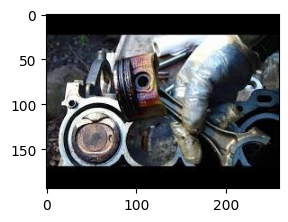


Original Class: imgi_103_images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction Class: Beval Gear



In [43]:
import matplotlib.image as mpimg # to read image in array

# Looping through each image and applying classify function
for img in images:
    # Reading image
    image = mpimg.imread(r'{}'.format(img))
    print("Given Image:")
    print()
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.show()
    print()
    print("Original Class:",img.split("/")[-1].split(".")[0])
    out = classify(image) # prediction function
    print("Prediction Class:",out.title())
    print()
    print("=================================================================")

**6. Saving Model For Model Deployment**

**In the callbacks, Best Model with Best Validation Score will be stored in kaggle/working**

- Click on file to download , wait for some time to show download

In [44]:
#### To save without callbacks

model.save("/kaggle/new_working/ImageClassify.h5") # Keras trained model will have save method